In [ ]:
!nvidia-smi

Mon Jul 18 16:51:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-2q_d_zma
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-2q_d_zma
     |████████████████████████████████| 48.3 MB 1.2 MB/s 
  Created wheel for albumentations: filename=albumentations-1.2.1-py3-none-any.whl size=116845 sha256=8b8e4eae69fdb617e18a51135fc9b34817b9a0b1bc3733878b0859ecb64ac529
  Stored in directory: /tmp/pip-ephem-wheel-cache-_33q9huq/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet18, resnet34
import os

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Section 1:Inference

In [ ]:
model = torchvision.models.detection.retinanet_resnet50_fpn(True)
model.to(device)

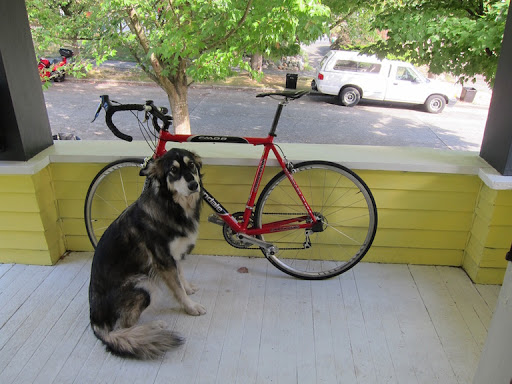

In [ ]:
from PIL import Image

img_pil = Image.open('/content/obj-det-test.jpg').convert('RGB')
display(img_pil)

In [ ]:
img_tensor = torchvision.transforms.functional.to_tensor(img_pil)
list_img = [img_tensor.to(device)]

model.eval()
with torch.no_grad():
  predictions = model(list_img)

predictions

In [ ]:
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

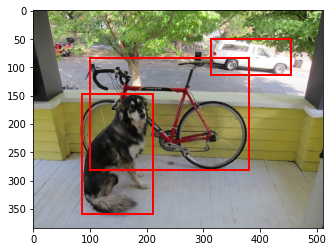

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

np_arr = img_tensor.permute(1, 2, 0).numpy()
plt.imshow(np_arr)

ax = plt.gca()
for box, label, score in zip(boxes, labels, scores):
  if score > 0.6:
    rect = Rectangle((box[0], box[1]),
                     (box[2] - box[0]),
                     (box[3] - box[1]),
                     fill=False,
                     edgecolor=(1, 0, 0),
                     linewidth=2)
    ax.add_patch(rect)

plt.show()

# Section 2: Fine-tune

## Custom dataset

In [ ]:
!curl -L "https://public.roboflow.com/ds/6F1fnWqEs1?key=ixsFJhWXgt" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
from PIL import Image
import os
import os.path
from typing import Any, Callable, Optional, Tuple, List


class CarDetection(torch.utils.data.Dataset):
    """`MS Coco Detection <https://cocodataset.org/#detection-2016>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        transforms (callable, optional): A function/transform that takes input sample and its target as entry
            and returns a transformed version.
    """

    def __init__(
        self,
        root: str,
        annFile: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ):
        # super().__init__(root, transforms, transform, target_transform)
        from pycocotools.coco import COCO

        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys())) 
        self.transforms = None

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")

    def _load_target(self, id) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)

        targets = {}
        targets['boxes'] = torch.tensor([item['bbox'] for item in target])#.view(-1, 4)
        targets['labels'] = torch.tensor([item['category_id'] for item in target])#.view(-1)

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        image = torchvision.transforms.functional.to_tensor(image)

        return image, targets

    def __len__(self) -> int:
        return len(self.ids)

In [ ]:
def get_loader(root, json, transform=None, batch_size=1, shuffle=False, num_workers=4):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    dataset = CarDetection(root=root,
                       annFile=json,
                       transform=transform)
    
    data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers)
    return data_loader, dataset

## Check and visualize dataset

In [ ]:
train_loader, train_set = get_loader('train', '/content/train/_annotations.coco.json', shuffle=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
batch = next(iter(train_loader))
batch[0].shape, batch[1]['boxes'].view(-1, 4), batch[1]['labels'].view(-1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(torch.Size([1, 3, 416, 416]),
 tensor([[  0.0000,  34.0000,  89.0000, 117.5000],
         [ 20.0000,  58.0000, 381.0000, 256.0000]]),
 tensor([3, 3]))

In [ ]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
import cv2
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(416, 416, 3)
[[232.  351.   12.5  11. ]
 [235.  350.   25.   22.5]]
tensor([3, 3])
['vehicles', 'Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']


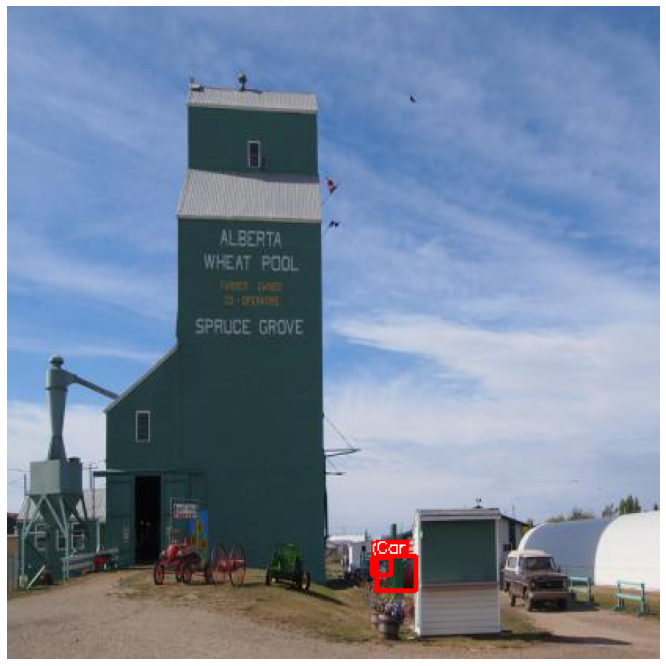

In [ ]:
batch = next(iter(train_loader))

image = batch[0][0].permute(1, 2, 0).numpy()
print(image.shape)

bboxes = batch[1]['boxes'].view(-1, 4).numpy()
print(bboxes)

category_ids = batch[1]['labels'].squeeze().view(-1)
print(category_ids)

cats = train_set.coco.loadCats(train_set.coco.getCatIds())
category_id_to_name = [cat['name'] for cat in cats]
print(category_id_to_name)

visualize(image, bboxes, category_ids.tolist(), category_id_to_name)

## Data augmentation

In [ ]:
import albumentations as A

In [ ]:
transform = A.Compose([A.HorizontalFlip(p=0.9)], 
                      bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

In [ ]:
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


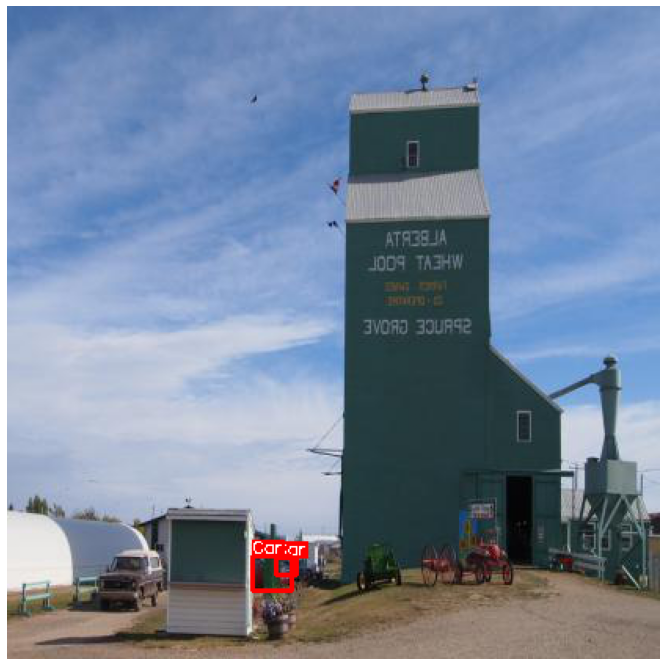

In [ ]:
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

In [ ]:
transform = A.Compose([A.HorizontalFlip(p=0.9),
                       A.ShiftScaleRotate(p=0.9),
                       A.RandomBrightness(p=0.3)], 
                      bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [ ]:
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


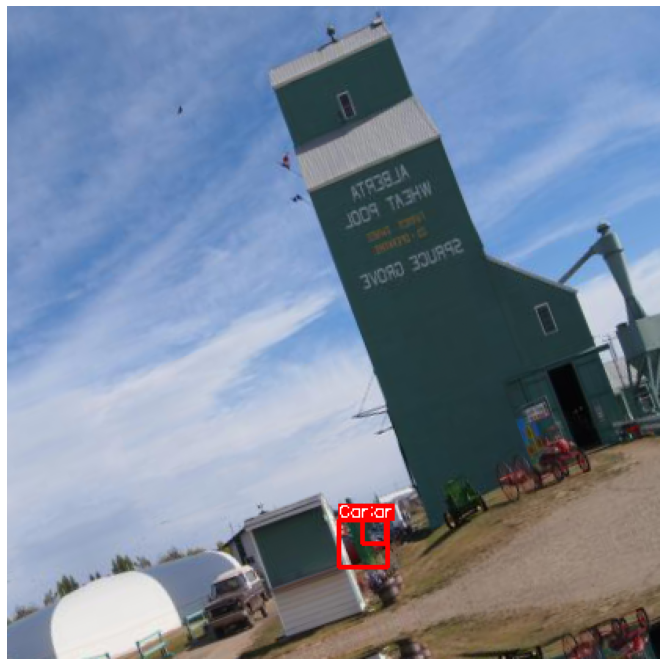

In [ ]:
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

## Custom dataset with augmentation

In [ ]:
from PIL import Image
import os
import os.path
from typing import Any, Callable, Optional, Tuple, List
import torchvision.transforms.functional as F

class CarDetection(torch.utils.data.Dataset):
    """`MS Coco Detection <https://cocodataset.org/#detection-2016>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        transforms (callable, optional): A function/transform that takes input sample and its target as entry
            and returns a transformed version.
    """

    def __init__(
        self,
        root: str,
        annFile: str,
        transforms: Optional[Callable] = None,
    ):
        # super().__init__(root, transforms, transform, target_transform)
        from pycocotools.coco import COCO

        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")

    def _load_target(self, id) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        # print(target)
        targets = {}
        targets['boxes'] = torch.tensor([item['bbox'] for item in target])#.view(-1, 4)
        targets['labels'] = torch.tensor([item['category_id'] for item in target])#.view(-1)

        if self.transforms is not None:
          image = F.to_tensor(image).permute(1, 2, 0).numpy()
          transformed = transform(image=image, bboxes=targets['boxes'], category_ids=targets['labels'])

        image = torch.tensor(transformed['image']).permute(2, 0, 1)
        targets['boxes'] = torch.tensor(transformed['bboxes'])
        if targets['boxes'].numel() > 0:
            targets['area'] = targets['boxes'][:, 2] * targets['boxes'][:, 3]
            # print(targets['boxes'].shape)
            targets['boxes'][:, 2] += targets['boxes'][:, 0]
            targets['boxes'][:, 3] += targets['boxes'][:, 1]
            targets['labels'] = torch.tensor(transformed['category_ids'])
            targets['image_id'] = torch.tensor(target[0]['image_id'])
            targets['iscrowd'] = torch.tensor([item['iscrowd'] for item in target])
        else:
            targets = {}

        return image, targets

    def __len__(self) -> int:
        return len(self.ids)

In [ ]:
def get_loader(root, json, transform=None, batch_size=1, shuffle=False, num_workers=4):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    dataset = CarDetection(root=root,
                       annFile=json,
                       transforms=transform)
    
    data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers)
    return data_loader, dataset

In [ ]:
transform = A.Compose([A.HorizontalFlip(p=0.9),
                       A.ShiftScaleRotate(p=0.9),
                       A.RandomBrightness(p=0.3)], 
                      bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [ ]:
train_loader, train_set = get_loader('train', '/content/train/_annotations.coco.json', shuffle=False, transform=transform)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
train_set[10]

(tensor([[[0.0222, 0.0170, 0.1002,  ..., 0.2486, 0.2370, 0.2272],
          [0.0474, 0.0085, 0.0499,  ..., 0.2560, 0.2426, 0.2257],
          [0.0442, 0.0018, 0.0319,  ..., 0.2637, 0.2468, 0.2310],
          ...,
          [0.1626, 0.1393, 0.1458,  ..., 0.0494, 0.0678, 0.1285],
          [0.1859, 0.1375, 0.1018,  ..., 0.0915, 0.1225, 0.1594],
          [0.3151, 0.1888, 0.1183,  ..., 0.1244, 0.1406, 0.1525]],
 
         [[0.0597, 0.0522, 0.1355,  ..., 0.3023, 0.2888, 0.2713],
          [0.0879, 0.0413, 0.0840,  ..., 0.3109, 0.2973, 0.2768],
          [0.0824, 0.0253, 0.0532,  ..., 0.3176, 0.3016, 0.2847],
          ...,
          [0.2598, 0.2334, 0.2467,  ..., 0.0993, 0.1135, 0.1717],
          [0.2830, 0.2316, 0.2093,  ..., 0.1312, 0.1638, 0.2026],
          [0.4110, 0.2829, 0.2321,  ..., 0.1656, 0.1831, 0.1956]],
 
         [[0.0364, 0.0326, 0.1159,  ..., 0.3539, 0.3490, 0.3366],
          [0.0654, 0.0222, 0.0648,  ..., 0.3618, 0.3490, 0.3393],
          [0.0608, 0.0085, 0.0382,  ...,

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(416, 416, 3)
[[ 51.45342039  34.10849656 395.99780085 311.06108188]]
tensor([3])
['vehicles', 'Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']


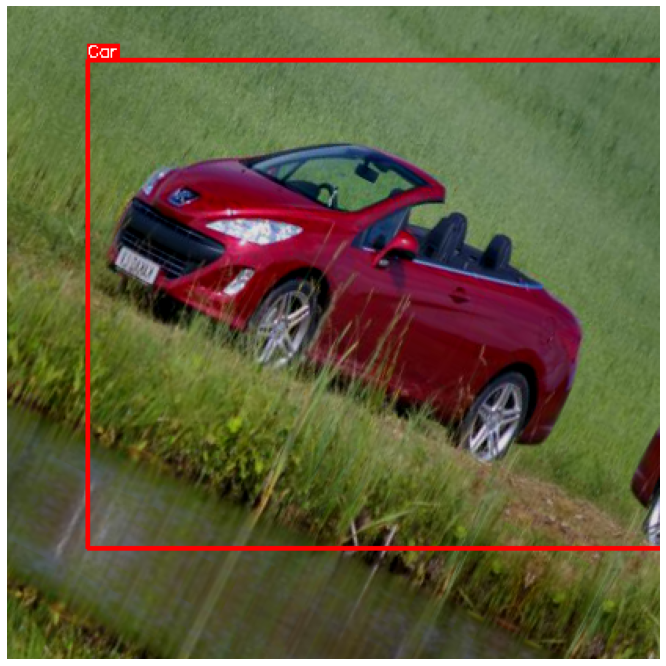

In [ ]:
batch = next(iter(train_loader))

image = batch[0][0].permute(1, 2, 0).numpy()
print(image.shape)

bboxes = batch[1]['boxes'].view(-1, 4).numpy()
print(bboxes)

category_ids = batch[1]['labels'].squeeze().view(-1)
print(category_ids)

cats = train_set.coco.loadCats(train_set.coco.getCatIds())
category_id_to_name = [cat['name'] for cat in cats]
print(category_id_to_name)

visualize(image, bboxes, category_ids.tolist(), category_id_to_name)

In [ ]:
import copy

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show() 

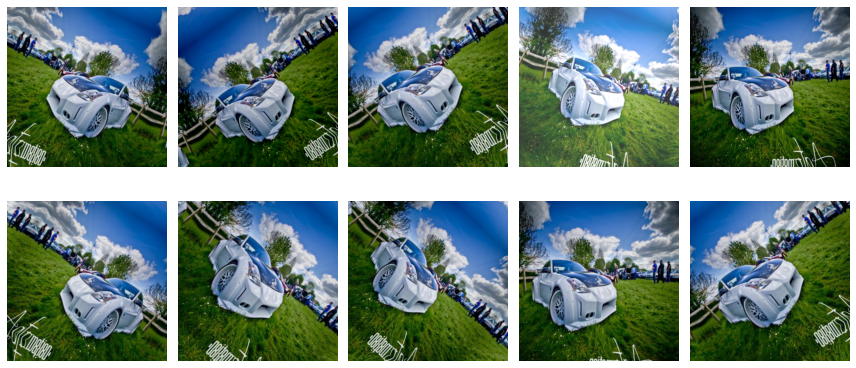

In [ ]:
visualize_augmentations(train_set, idx=10)

## datasets

In [ ]:
transform_train = A.Compose([A.HorizontalFlip(p=0.9),
                       A.ShiftScaleRotate(p=0.9),
                       A.RandomBrightness(p=0.3)], 
                      bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

transform_test = A.Compose([A.Resize(416, 416)], 
                      bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [ ]:
def new_concat(batch):
  return tuple(zip(*batch))

In [ ]:
def get_loader(root, json, transform=None, batch_size=1, shuffle=False, num_workers=4):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    dataset = CarDetection(root=root,
                       annFile=json,
                       transforms=transform)
    
    data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=new_concat)
    return data_loader, dataset

In [ ]:
trainloader, trainset = get_loader('train', '/content/train/_annotations.coco.json', shuffle=True, transform=transform_train)

testloader, testset = get_loader('test', '/content/test/_annotations.coco.json', shuffle=True, transform=transform_test)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
batch = next(iter(trainloader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
batch[0], batch[1]

((tensor([[[0.5625, 0.6426, 0.6778,  ..., 0.1822, 0.2765, 0.5412],
           [0.4672, 0.5395, 0.5772,  ..., 0.1675, 0.1834, 0.2960],
           [0.4941, 0.4837, 0.5048,  ..., 0.1419, 0.1697, 0.1917],
           ...,
           [0.4690, 0.5009, 0.3748,  ..., 0.3625, 0.3615, 0.3528],
           [0.3455, 0.2896, 0.3733,  ..., 0.3583, 0.3599, 0.3553],
           [0.3837, 0.2678, 0.2834,  ..., 0.3446, 0.3536, 0.3529]],
  
          [[0.5696, 0.6400, 0.6778,  ..., 0.1467, 0.2088, 0.3647],
           [0.4632, 0.5356, 0.5749,  ..., 0.1283, 0.1447, 0.2153],
           [0.4902, 0.4797, 0.5009,  ..., 0.1024, 0.1207, 0.1454],
           ...,
           [0.4549, 0.4858, 0.3623,  ..., 0.3615, 0.3615, 0.3528],
           [0.3241, 0.2650, 0.3494,  ..., 0.3583, 0.3599, 0.3553],
           [0.3576, 0.2336, 0.2476,  ..., 0.3446, 0.3536, 0.3529]],
  
          [[0.5469, 0.6163, 0.6464,  ..., 0.0867, 0.0892, 0.1333],
           [0.4436, 0.5160, 0.5505,  ..., 0.0890, 0.0851, 0.0995],
           [0.4706, 0.

In [ ]:
images = [image.to(device) for image in batch[0]]
targets = [{k: v.to(device) for k, v in t.items()} for t in batch[1]]

In [ ]:
images

[tensor([[[0.5625, 0.6426, 0.6778,  ..., 0.1822, 0.2765, 0.5412],
          [0.4672, 0.5395, 0.5772,  ..., 0.1675, 0.1834, 0.2960],
          [0.4941, 0.4837, 0.5048,  ..., 0.1419, 0.1697, 0.1917],
          ...,
          [0.4690, 0.5009, 0.3748,  ..., 0.3625, 0.3615, 0.3528],
          [0.3455, 0.2896, 0.3733,  ..., 0.3583, 0.3599, 0.3553],
          [0.3837, 0.2678, 0.2834,  ..., 0.3446, 0.3536, 0.3529]],
 
         [[0.5696, 0.6400, 0.6778,  ..., 0.1467, 0.2088, 0.3647],
          [0.4632, 0.5356, 0.5749,  ..., 0.1283, 0.1447, 0.2153],
          [0.4902, 0.4797, 0.5009,  ..., 0.1024, 0.1207, 0.1454],
          ...,
          [0.4549, 0.4858, 0.3623,  ..., 0.3615, 0.3615, 0.3528],
          [0.3241, 0.2650, 0.3494,  ..., 0.3583, 0.3599, 0.3553],
          [0.3576, 0.2336, 0.2476,  ..., 0.3446, 0.3536, 0.3529]],
 
         [[0.5469, 0.6163, 0.6464,  ..., 0.0867, 0.0892, 0.1333],
          [0.4436, 0.5160, 0.5505,  ..., 0.0890, 0.0851, 0.0995],
          [0.4706, 0.4601, 0.4813,  ...,

In [ ]:
targets

[{'area': tensor([89800.7496, 27022.1000], device='cuda:0', dtype=torch.float64),
  'boxes': tensor([[129.3451,   0.0000, 416.0000, 313.2713],
          [ 62.3660, 256.2574, 231.5263, 416.0000]], device='cuda:0',
         dtype=torch.float64),
  'image_id': tensor(115, device='cuda:0'),
  'iscrowd': tensor([0, 0], device='cuda:0'),
  'labels': tensor([5, 5], device='cuda:0')}]

## Model

In [ ]:
net = torchvision.models.detection.retinanet_resnet50_fpn(True)
net.to(device)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


## Config

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
import sys
import logging
from torch.utils.tensorboard import SummaryWriter
logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger('FineTune')
# logger.setLevel(logging.INFO)
writer = SummaryWriter()

In [ ]:
logging.info('test')

INFO:root:test


In [ ]:
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20000)

## Train & Test

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 22444, done.
remote: Counting objects: 100% (3225/3225), done.
remote: Compressing objects: 100% (797/797), done.
remote: Total 22444 (delta 2470), reused 3043 (delta 2348), pack-reused 19219
Receiving objects: 100% (22444/22444), 27.08 MiB | 26.74 MiB/s, done.
Resolving deltas: 100% (16531/16531), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
from engine import train_one_epoch, evaluate
import utils

In [ ]:
# Training
def train(epoch):
    net.train()
    loss_total = AverageMeter()
    # accuracy = torchmetrics.Accuracy().cuda()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # inputs, targets = inputs.to(device), targets.to(device)
        inputs = [image.to(device) for image in inputs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        loss_dict = net(inputs, targets)
        loss = sum(loss for loss in loss_dict.values())
        # loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_total.update(loss)
        # accuracy(outputs.softmax(dim=-1), targets)
        # print(targets[:10])
        # if batch_idx == 20:
        #     break
        scheduler.step()
    # acc = accuracy.compute()
    writer.add_scalar('Loss/train', loss_total.avg.item(), epoch)
    # writer.add_scalar('Acc/train', acc.item(), epoch)
    logger.info(f'Train: Epoch:{epoch} Loss:{loss_total.avg:.4}')
    # logger.info(f'Train: Epoch:{epoch} Loss:{loss_total.avg:.4} Accuracy:{acc:.4}')
    

def test(epoch, checkpoint):
    net.eval()
    loss_total = AverageMeter()
    # accuracy = torchmetrics.Accuracy().cuda()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            # inputs, targets = inputs.to(device), targets.to(device)
            inputs = [image.to(device) for image in inputs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = net(inputs)
            # loss = criterion(outputs, targets)
            # loss_total.update(loss)
            # accuracy(outputs.softmax(dim=-1), targets)
        # acc = accuracy.compute()
        # writer.add_scalar('Loss/test', loss_total.avg.item(), epoch)
        # writer.add_scalar('Acc/test', acc.item(), epoch)
        # logger.info(f'Train: Epoch:{epoch} Loss:{loss_total.avg:.4}')
        # logger.info(f'Test:  Epoch:{epoch} Loss:{loss_total.avg:.4} Accuracy:{acc:.4}')
        print()
    # Save checkpoint
    checkpoint.save(accuracy.compute(), epoch=epoch)


class Checkpoint(object):
    def __init__(self, model_name):
        self.best_acc = 0.
        self.folder = 'checkpoint'
        self.model_name = model_name
        os.makedirs(self.folder, exist_ok=True)
    def save(self, acc, epoch=-1):
        if acc > self.best_acc:
            logger.info('Saving checkpoint...')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            path = os.path.join(os.path.abspath(self.folder), self.model_name + '.pth')
            torch.save(state, path)
            self.best_acc = acc
    def load(self, net):
        pass

In [ ]:
# writer = SummaryWriter()
checkpoint = Checkpoint('ckpt-retina-dar-detection')
start, end = 0, 10
for epoch in range(start, end):
    train(epoch)
    # test(epoch, checkpoint)
    evaluate(net, testloader, device=device)

writer.close()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
INFO:FineTune:Train: Epoch:0 Loss:0.776


creating index...
index created!
Test:  [ 0/63]  eta: 0:00:19  model_time: 0.1013 (0.1013)  evaluator_time: 0.0142 (0.0142)  time: 0.3056  data: 0.1883  max mem: 2424
Test:  [62/63]  eta: 0:00:00  model_time: 0.0598 (0.0609)  evaluator_time: 0.0036 (0.0058)  time: 0.0696  data: 0.0037  max mem: 2424
Test: Total time: 0:00:04 (0.0754 s / it)
Averaged stats: model_time: 0.0598 (0.0609)  evaluator_time: 0.0036 (0.0058)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.223
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:1 Loss:0.6432


creating index...
index created!
Test:  [ 0/63]  eta: 0:00:17  model_time: 0.1054 (0.1054)  evaluator_time: 0.0051 (0.0051)  time: 0.2770  data: 0.1648  max mem: 2424
Test:  [62/63]  eta: 0:00:00  model_time: 0.0601 (0.0614)  evaluator_time: 0.0067 (0.0078)  time: 0.0717  data: 0.0035  max mem: 2424
Test: Total time: 0:00:04 (0.0776 s / it)
Averaged stats: model_time: 0.0601 (0.0614)  evaluator_time: 0.0067 (0.0078)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.185
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:2 Loss:0.5844


creating index...
index created!
Test:  [ 0/63]  eta: 0:00:17  model_time: 0.1114 (0.1114)  evaluator_time: 0.0070 (0.0070)  time: 0.2788  data: 0.1586  max mem: 2424
Test:  [62/63]  eta: 0:00:00  model_time: 0.0592 (0.0603)  evaluator_time: 0.0037 (0.0046)  time: 0.0690  data: 0.0035  max mem: 2424
Test: Total time: 0:00:04 (0.0732 s / it)
Averaged stats: model_time: 0.0592 (0.0603)  evaluator_time: 0.0037 (0.0046)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.160
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:3 Loss:0.5716


creating index...
index created!
Test:  [ 0/63]  eta: 0:00:19  model_time: 0.0641 (0.0641)  evaluator_time: 0.0061 (0.0061)  time: 0.3019  data: 0.2297  max mem: 2424
Test:  [62/63]  eta: 0:00:00  model_time: 0.0598 (0.0602)  evaluator_time: 0.0043 (0.0062)  time: 0.0702  data: 0.0035  max mem: 2424
Test: Total time: 0:00:04 (0.0758 s / it)
Averaged stats: model_time: 0.0598 (0.0602)  evaluator_time: 0.0043 (0.0062)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.208
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.371
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.250
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:4 Loss:0.5093


creating index...
index created!
Test:  [ 0/63]  eta: 0:00:21  model_time: 0.0741 (0.0741)  evaluator_time: 0.0243 (0.0243)  time: 0.3485  data: 0.2485  max mem: 2424
Test:  [62/63]  eta: 0:00:00  model_time: 0.0592 (0.0599)  evaluator_time: 0.0032 (0.0056)  time: 0.0694  data: 0.0035  max mem: 2424
Test: Total time: 0:00:04 (0.0751 s / it)
Averaged stats: model_time: 0.0592 (0.0599)  evaluator_time: 0.0032 (0.0056)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.205
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:5 Loss:0.4944


creating index...
index created!
Test:  [ 0/63]  eta: 0:00:18  model_time: 0.0800 (0.0800)  evaluator_time: 0.0030 (0.0030)  time: 0.2959  data: 0.2112  max mem: 2424
Test:  [62/63]  eta: 0:00:00  model_time: 0.0593 (0.0599)  evaluator_time: 0.0027 (0.0100)  time: 0.0691  data: 0.0034  max mem: 2424
Test: Total time: 0:00:04 (0.0792 s / it)
Averaged stats: model_time: 0.0593 (0.0599)  evaluator_time: 0.0027 (0.0100)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.406
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.221
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:6 Loss:0.4784


creating index...
index created!
Test:  [ 0/63]  eta: 0:00:17  model_time: 0.0928 (0.0928)  evaluator_time: 0.0062 (0.0062)  time: 0.2823  data: 0.1816  max mem: 2424
Test:  [62/63]  eta: 0:00:00  model_time: 0.0596 (0.0604)  evaluator_time: 0.0045 (0.0062)  time: 0.0702  data: 0.0033  max mem: 2424
Test: Total time: 0:00:04 (0.0754 s / it)
Averaged stats: model_time: 0.0596 (0.0604)  evaluator_time: 0.0045 (0.0062)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.177
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:7 Loss:0.4825


creating index...
index created!
Test:  [ 0/63]  eta: 0:00:19  model_time: 0.0783 (0.0783)  evaluator_time: 0.0031 (0.0031)  time: 0.3019  data: 0.2188  max mem: 2424
Test:  [62/63]  eta: 0:00:00  model_time: 0.0588 (0.0597)  evaluator_time: 0.0025 (0.0040)  time: 0.0669  data: 0.0034  max mem: 2424
Test: Total time: 0:00:04 (0.0728 s / it)
Averaged stats: model_time: 0.0588 (0.0597)  evaluator_time: 0.0025 (0.0040)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.222
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:8 Loss:0.442


creating index...
index created!
Test:  [ 0/63]  eta: 0:00:18  model_time: 0.0883 (0.0883)  evaluator_time: 0.0026 (0.0026)  time: 0.2974  data: 0.2048  max mem: 2424
Test:  [62/63]  eta: 0:00:00  model_time: 0.0587 (0.0595)  evaluator_time: 0.0028 (0.0031)  time: 0.0665  data: 0.0034  max mem: 2424
Test: Total time: 0:00:04 (0.0718 s / it)
Averaged stats: model_time: 0.0587 (0.0595)  evaluator_time: 0.0028 (0.0031)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.214
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:9 Loss:0.4192


creating index...
index created!
Test:  [ 0/63]  eta: 0:00:18  model_time: 0.1056 (0.1056)  evaluator_time: 0.0055 (0.0055)  time: 0.2897  data: 0.1770  max mem: 2424
Test:  [62/63]  eta: 0:00:00  model_time: 0.0593 (0.0604)  evaluator_time: 0.0031 (0.0058)  time: 0.0697  data: 0.0034  max mem: 2424
Test: Total time: 0:00:04 (0.0749 s / it)
Averaged stats: model_time: 0.0593 (0.0604)  evaluator_time: 0.0031 (0.0058)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.235
 Average Recall     (AR) @[ IoU=

## Predict

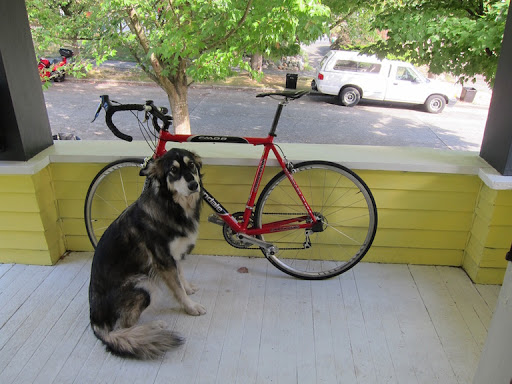

In [ ]:
from PIL import Image

img_pil = Image.open('/content/obj-det-test.jpg').convert('RGB')
display(img_pil)

In [ ]:
img_tensor = torchvision.transforms.functional.to_tensor(img_pil)
list_img = [img_tensor.to(device)]

net.eval()
with torch.no_grad():
  predictions = net(list_img)

predictions

In [ ]:
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

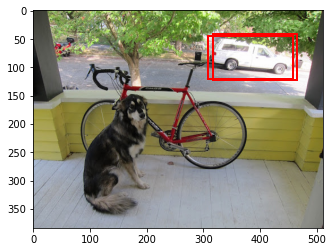

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

np_arr = img_tensor.permute(1, 2, 0).numpy()
plt.imshow(np_arr)

ax = plt.gca()
for box, label, score in zip(boxes, labels, scores):
  if score > 0.6:
    rect = Rectangle((box[0], box[1]),
                     (box[2] - box[0]),
                     (box[3] - box[1]),
                     fill=False,
                     edgecolor=(1, 0, 0),
                     linewidth=2)
    ax.add_patch(rect)

plt.show()

# RetinaNet with MobileNet

In [ ]:
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.anchor_utils import AnchorGenerator

In [ ]:
backbone = torchvision.models.mobilenet_v2(True).features
backbone.out_channels = 1280

In [ ]:
anchors = AnchorGenerator(sizes=((32, 64, 128, 256, 512), ),
                          aspect_ratios=((0.5, 1.0, 2.0), ))

In [ ]:
net = RetinaNet(backbone, 7, anchor_generator=anchors)
net.to(device)

In [ ]:
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20000)

In [ ]:
# writer = SummaryWriter()
checkpoint = Checkpoint('ckpt-retina-mbnet-detection')
start, end = 0, 10
for epoch in range(start, end):
    train(epoch)
    # test(epoch, checkpoint)
    evaluate(net, testloader, device=device)

writer.close()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
INFO:FineTune:Train: Epoch:0 Loss:1.666


creating index...
index created!
Test:  [ 0/63]  eta: 0:00:19  model_time: 0.0767 (0.0767)  evaluator_time: 0.0021 (0.0021)  time: 0.3021  data: 0.2216  max mem: 3460
Test:  [62/63]  eta: 0:00:00  model_time: 0.0579 (0.0614)  evaluator_time: 0.0006 (0.0007)  time: 0.0636  data: 0.0036  max mem: 3460
Test: Total time: 0:00:04 (0.0721 s / it)
Averaged stats: model_time: 0.0579 (0.0614)  evaluator_time: 0.0006 (0.0007)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:1 Loss:1.598


creating index...
index created!
Test:  [ 0/63]  eta: 0:00:19  model_time: 0.0907 (0.0907)  evaluator_time: 0.0017 (0.0017)  time: 0.3124  data: 0.2182  max mem: 3460
Test:  [62/63]  eta: 0:00:00  model_time: 0.0583 (0.0593)  evaluator_time: 0.0006 (0.0007)  time: 0.0642  data: 0.0036  max mem: 3460
Test: Total time: 0:00:04 (0.0700 s / it)
Averaged stats: model_time: 0.0583 (0.0593)  evaluator_time: 0.0006 (0.0007)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=

INFO:FineTune:Train: Epoch:2 Loss:1.613


creating index...
index created!
Test:  [ 0/63]  eta: 0:00:20  model_time: 0.0770 (0.0770)  evaluator_time: 0.0012 (0.0012)  time: 0.3281  data: 0.2482  max mem: 3460
Test:  [62/63]  eta: 0:00:00  model_time: 0.0583 (0.0591)  evaluator_time: 0.0006 (0.0007)  time: 0.0641  data: 0.0036  max mem: 3460
Test: Total time: 0:00:04 (0.0704 s / it)
Averaged stats: model_time: 0.0583 (0.0591)  evaluator_time: 0.0006 (0.0007)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=

KeyError: ignored

# Models

In [ ]:
model = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet18', True)
model

In [ ]:
output = model(torch.randn(1, 3, 224, 224))

In [ ]:
print([(k, v.shape) for k, v in output.items()])

[('0', torch.Size([1, 256, 56, 56])), ('1', torch.Size([1, 256, 28, 28])), ('2', torch.Size([1, 256, 14, 14])), ('3', torch.Size([1, 256, 7, 7])), ('pool', torch.Size([1, 256, 4, 4]))]


## MobileNet with FPN

In [ ]:
from torchvision.models import mobilenet_v2
from torchvision.models.detection.backbone_utils import BackboneWithFPN

In [ ]:
class FPNMobileNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        net = mobilenet_v2(pretrained)
        features = net.features
        self.layer1= nn.Sequential(*features[0:4])
        self.layer2 = nn.Sequential(*features[4:7])
        self.layer3 = nn.Sequential(*features[7:11])
        self.layer4 = nn.Sequential(*features[11:19])
        for param in features.parameters():
            param.requires_grad = False

    def forward(self, x):

        # Bottom-up pathway, from ResNet
        enc0 = self.layer1(x) # 24
        enc1 = self.layer2(enc0) # 32
        enc2 = self.layer3(enc1) # 64
        enc3 = self.layer4(enc2) # 1280
        return enc3


def mobilenet_fpn_backbone(pretrained):
    backbone = FPNMobileNet(pretrained)
    # freeze layers
    for name, parameter in backbone.named_parameters():
        if 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
            parameter.requires_grad_(False)

    return_layers = {'layer1': 0, 'layer2': 1, 'layer3': 2, 'layer4': 3}

    in_channels_list = [
       24, 32, 64, 1280
    ]
    
    out_channels = 256
    return BackboneWithFPN(backbone, return_layers, in_channels_list, out_channels)

In [ ]:
model = mobilenet_fpn_backbone(True)

In [ ]:
output = model(torch.randn(1, 3, 224, 224))

In [ ]:
print([(k, v.shape) for k, v in output.items()])

[('0', torch.Size([1, 256, 56, 56])), ('1', torch.Size([1, 256, 28, 28])), ('2', torch.Size([1, 256, 14, 14])), ('3', torch.Size([1, 256, 7, 7])), ('pool', torch.Size([1, 256, 4, 4]))]


## Mobilenet without Custom Class

In [ ]:
from torchvision.models._utils import IntermediateLayerGetter

In [ ]:
backbone = mobilenet_v2(True).features
backbone

Sequential(
  (0): ConvBNActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(in

In [ ]:
return_layers = {'4': 0, '7': 1, '11': 2, '19': 3}

In [ ]:
IntermediateLayerGetter(backbone, return_layers=return_layers)

ValueError: ignored

In [ ]:
backbone = FPNMobileNet(True)

return_layers = {'layer1': 0, 'layer2': 1, 'layer3': 2, 'layer4': 3}

In [ ]:
m = IntermediateLayerGetter(backbone, return_layers=return_layers)

In [ ]:
output = m(torch.rand(1, 3, 224, 224))

In [ ]:
print([(k, v.shape) for k, v in output.items()])

[(0, torch.Size([1, 24, 56, 56])), (1, torch.Size([1, 32, 28, 28])), (2, torch.Size([1, 64, 14, 14])), (3, torch.Size([1, 1280, 7, 7]))]


In [ ]:
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork

In [ ]:
n = FeaturePyramidNetwork([24, 32, 64, 1280], 512)
n

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2d(24, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(32, 512, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(64, 512, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(1280, 512, kernel_size=(1, 1), stride=(1, 1))
  )
  (layer_blocks): ModuleList(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
output2 = n(output)

In [ ]:
print([(k, v.shape) for k, v in output2.items()])

[(0, torch.Size([1, 512, 56, 56])), (1, torch.Size([1, 512, 28, 28])), (2, torch.Size([1, 512, 14, 14])), (3, torch.Size([1, 512, 7, 7]))]


In [ ]:
n2 = FeaturePyramidNetwork([512, 512, 512, 512], 1024)
n2

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
  )
  (layer_blocks): ModuleList(
    (0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
output3 = n2(output2)

In [ ]:
print([(k, v.shape) for k, v in output3.items()])

[(0, torch.Size([1, 1024, 56, 56])), (1, torch.Size([1, 1024, 28, 28])), (2, torch.Size([1, 1024, 14, 14])), (3, torch.Size([1, 1024, 7, 7]))]
